In [1]:
import os
import pandas as pd

In [2]:
df = pd.read_csv('/home/jnicolow/projects/NUMTscan/data/training_data.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
# boldDf = pd.read_csv('/home/jnicolow/projects/NUMTscan/data/BOLD_sequences.csv')

In [3]:
# pd.set_option('display.max_rows', None)
pd.reset_option('display.max_rows')
grouped_df = df.groupby(['Species', 'numt'])['AminoAcidSeq'].count().reset_index()
filtered_species = grouped_df[(grouped_df['numt'] == True) & (grouped_df['AminoAcidSeq'] > 100)]['Species']
result_df = grouped_df[grouped_df['Species'].isin(filtered_species)]
species_list = ['Bemisia tabaci', 'Periplaneta americana', 'Locusta migratoria']
filtered_df = result_df[result_df['Species'].isin(species_list)]

print(filtered_df['AminoAcidSeq'].sum())
filtered_df.to_csv(os.path.join('data', 'modelSpecies.csv'), index=False)

7804


In [4]:
filtered_df

,Species,numt,AminoAcidSeq
101,Bemisia tabaci,False,5872
102,Bemisia tabaci,True,339
339,Locusta migratoria,False,409
340,Locusta migratoria,True,557
481,Periplaneta americana,False,91
482,Periplaneta americana,True,536


In [21]:
modelDf = df[(df['Species'] =='Bemisia tabaci') | (df['Species'] =='Periplaneta americana') | (df['Species'] =='Locusta migratoria')]

In [22]:
modelDf['Species'].unique()


array(['Bemisia tabaci', 'Locusta migratoria', 'Periplaneta americana'],
      dtype=object)

# 1. Load data

In [3]:
trainingDfPath = os.path.join('data', 'training_data.csv')

if not os.path.exists(trainingDfPath):

    dfNumt = pd.read_csv(os.path.join('data', 'NUMT_reliable_hits_with_protein_seq.csv'))
    dfBOLD = pd.read_csv(os.path.join('data', 'BOLD_seqs_with_protein.csv'))
    dfNumt['numt'] = True
    dfBOLD['numt'] = False

    dfBOLD.rename(columns={'species': 'Species', 
                        'sequence': 'Sequence'}, inplace=True) # CAREFUL THE NAMES MAY BE UPDATED TO MACH AND THIS WOULD NOT BE NEEDED

    df = pd.concat([dfNumt, dfBOLD], axis = 0)

    dfCombined = df[['Species', 'Sequence', 'AminoAcidSeq', 'numt']]
    dfCombined.columns = ['Species', 'Sequence', 'AminoAcidSeq', 'numt']
    dfCombined.reset_index(inplace=True, drop=True)
    dfCombined.to_csv(trainingDfPath, index=False)
else:
    dfCombined = pd.read_csv(trainingDfPath)


dfCombined = dfCombined[(dfCombined['Species'] =='Bemisia tabaci') | (dfCombined['Species'] =='Periplaneta americana') | (dfCombined['Species'] =='Locusta migratoria')]
print(len(dfCombined))
dfCombined.drop_duplicates(subset='Sequence', keep='first', inplace=True) # keep first because numts are first and if ones in numt and bnold we just want the numt
print(len(dfCombined))
dfCombined.drop_duplicates(subset='AminoAcidSeq', keep='first', inplace=True) # keep first because numts are first and if ones in numt and bnold we just want the numt
print(len(dfCombined))
display(dfCombined)

7804
7804
4609


,Unnamed: 0,Species,Sequence,AminoAcidSeq,numt
1372,1372,Bemisia tabaci,GATCCTATTTTATATCAGCACTTGTTCTGGTTTTTTGGTCATCCAG...,MIYAMLTIGILGFIVWGHHMFTVGMDVDTRAYFTSATMIIAVPTGI...,True
1373,1373,Bemisia tabaci,GCATTTATTCTGGTTCTTTGGTCATCCAGAGGTTTATGTTCTTATC...,MIYAMLTIGILGFIVWGHHMFTVGMDVDTRAYFTSATMIIAVPTGI...,True
1374,1374,Bemisia tabaci,TGAAAGTTTGAGCTTTTTCGACTAACCACAAAGATATCGGTGTTTT...,MIIRSELMNVGSFMSNEHLYNVVVTSHAFIMIFFMTMPLVIGGFGN...,True
1375,1375,Bemisia tabaci,TGAAAGTTTGAGCTTTTTCGACTAACCACAAAGATATTGGTGTTTT...,MTMPLVIGGFGNWLIPLMIGAPDMAFPRMNNLSFWLLVPSLIFMLV...,True
1376,1376,Bemisia tabaci,TCCCTCATTAATTTTTATGTTGGTTAGAATGATTATTAGGACAGGA...,MLVSMIISTGAGTGWTVYPPLSLSLTHSGLSVDLLIFSLHIAGISS...,True
...,...,...,...,...,...
40784,40784,Periplaneta americana,GATCAGGTATAGTAGGAACATCACTAAGAATACTAATTCGTGCTGA...,MVGTSLSMLIRAELGQPGSLIGDDQIYNVIVTAHAFIMIFFMVMPI...,False
40786,40786,Periplaneta americana,AACATTATATTTTATTTTCGGTGCCTGATCAGGTATAGTGGGAACA...,MVGTSMSMLIRAELGQPGSLIGDDQIYNVIVTAHAFIMIFFMVMPI...,False
40787,40787,Periplaneta americana,AACATTATATTTTATTTTCGGTGCCTGATCAGGTATAGTGGGAACA...,MVGTSLSMLIRAELGQPGSLIGDDQIYNVIVTAHAFIMIFFMVMPI...,False
40788,40788,Periplaneta americana,TACCATTAATATTAGGAGCCCCAGATATAGCCTTCCCACGAATAAA...,MLGAPDMAFPRMNNMSFWLLPPSLTLLLASSMVESGAGTGWTVYPP...,False


# 2. Load Model

In [4]:
import torch
import esm

# Load ESM-2 model
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results

# use extract.py to generate all the embedings in batch mode and save them (use GPU)

ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0-32): 33 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
  )
  (contact_head): ContactPredictionHead(
    (regression): Linear(in_features=660, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (emb_layer_norm_after): LayerNorm((1280,), eps=1

# 3. Get Embedings 5 batch size 5
currently just doing the first n

In [5]:
i=0
sequences = dfCombined['AminoAcidSeq'].tolist()[i:i+5]
numtVals = dfCombined['numt'].tolist()[i:i+5]

def get_embeddings_batch(sequences, saveCLS=False):
        _, _, batch_tokens = batch_converter(list(enumerate(sequences)))

        with torch.no_grad():
                results = model(batch_tokens, repr_layers=[33], return_contacts=True) # use the representation from the 33rd layer

        sequenceEmbedings = {}

        for i, seq in enumerate(sequences):
                if saveCLS:
                        trimmedRep = results['representations'][33][i][0:len(seq)+2]
                else:
                        trimmedRep = results['representations'][33][i][1:1+len(seq)] # the first and last embeding are padding adn every thing after the length of the sequence is padding
                sequenceEmbedings[seq] = trimmedRep#.mean(0) # mean pooling for representation of entire protein sequence
        return(sequenceEmbedings)

# test = get_embeddings_batch(sequences)

In [48]:
import h5py
embeddings = get_embeddings_batch(sequences)

with h5py.File('amino_acid_data.hdf5', 'w') as f:
    for i, seq in enumerate(sequences):
        grp = f.create_group(seq)
        grp.create_dataset("numt", data=numtVals[i])
        grp.create_dataset("embedding", data=embeddings[seq].numpy())  # assuming embeddings are PyTorch tensors

In [1]:
dfTest = dfCombined[dfCombined['Species'] == 'Bemisia tabaci'].sample(100)
import h5py
import torch
import gc

def get_embeddings_batch(sequences, saveCLS=False):
    _, _, batch_tokens = batch_converter(list(enumerate(sequences)))

    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[33], return_contacts=True)

    sequenceEmbedings = {}

    for i, seq in enumerate(sequences):
        if saveCLS:
            trimmedRep = results['representations'][33][i][0:len(seq)+2]
        else:
            trimmedRep = results['representations'][33][i][1:1+len(seq)]
        sequenceEmbedings[seq] = trimmedRep
    return sequenceEmbedings

# Define the batch size
batch_size = 2

# Open the HDF5 file
with h5py.File('amino_acid_data.hdf5', 'w') as f:
    # Loop through the DataFrame in batches
    for i in range(0, len(dfTest), batch_size):
        if i <= 65: continue
        sequences = dfTest['AminoAcidSeq'].tolist()[i:i+batch_size]
        numtVals = dfTest['numt'].tolist()[i:i+batch_size]

        # Get the embeddings for the current batch
        embeddings = get_embeddings_batch(sequences)

        # Save the embeddings to the HDF5 file
        for j, seq in enumerate(sequences):
            grp = f.create_group(seq)
            grp.create_dataset("numt", data=numtVals[j])
            grp.create_dataset("embedding", data=embeddings[seq].numpy())
            del embeddings[seq]
            gc.collect() # free up RAM


NameError: name 'dfCombined' is not defined

In [1]:
import os
import h5py
scratchPath = '/mnt/lustre/koa/scratch/jnicolow'
dataFile = os.path.join(scratchPath, 'amino_acid_data.hdf5')
file = h5py.File(dataFile, 'r')  # 'myfile.hdf5' is your filename


In [11]:
keylist = list(file.keys())
numtCount = 0
cherryCount = 0
for key in keylist:
    if file[key]['numt'][()]:
        numtCount+=1
    else:
        cherryCount+=1

print(f'num numts: {numtCount}, num good examples {cherryCount}')

num numts: 145, num good examples 0


In [15]:
len(keylist)

145

In [14]:
for key in keylist:
    print(file[key]['embedding'][])
    break

<HDF5 dataset "embedding": shape (34, 1280), type "<f4">


In [23]:
dir_path = '/mnt/lustre/koa/scratch/jnicolow'

# Check if the directory exists
if os.path.exists(dir_path):
    print(f"The directory {dir_path} exists.")
else:
    print(f"The directory {dir_path} does not exist.")

The directory /mnt/lustre/koa/scratch/jnicolow exists.


In [8]:
dfCombinedSmall = dfCombined.sample(n=400, random_state=42)#.iloc[0:10].copy()
N = 30
embeddingDf = dfCombinedSmall.groupby(dfCombinedSmall.index // N)['AminoAcidSeq'].apply(get_embeddings_batch).reset_index(level = 0, drop=True)
embeddingDf = embeddingDf.reset_index().rename(columns={'index':'AminoAcidSeq2'})
embeddingDf = embeddingDf.rename(columns={'AminoAcidSeq2':'AminoAcidSeq', 'AminoAcidSeq':'embeddings'})
dfCombinedSmall = dfCombinedSmall.merge(embeddingDf[['AminoAcidSeq', 'embeddings']], on='AminoAcidSeq', how='left')

In [6]:
import numpy as np

# Define the size of the chunks and the number of chunks to process at a time
N = 30
chunk_size = 400
chunks_at_a_time = 30

dfCombinedTest = dfCombined.sample(n=800, random_state=42)

# Calculate the total number of chunks
total_chunks = np.ceil(len(dfCombinedTest) / chunk_size)

# Process and save the data in chunks
for i in range(0, int(total_chunks), chunks_at_a_time):
    # Get the current chunk of data
    dfCombinedSmall = dfCombinedTest.iloc[i*chunk_size:(i+chunks_at_a_time)*chunk_size].copy()
    
    # Get embeddings for each group of N rows
    embeddingDf = dfCombinedSmall.groupby(dfCombinedSmall.index // N)['AminoAcidSeq'].apply(get_embeddings_batch).reset_index(level = 0, drop=True)
    
    # Reset and rename the index
    embeddingDf = embeddingDf.reset_index().rename(columns={'index':'AminoAcidSeq2'})
    embeddingDf = embeddingDf.rename(columns={'AminoAcidSeq2':'AminoAcidSeq', 'AminoAcidSeq':'embeddings'})
    
    # Merge the embeddings back into dfCombinedSmall
    dfCombinedSmall = dfCombinedSmall.merge(embeddingDf[['AminoAcidSeq', 'embeddings']], on='AminoAcidSeq', how='left')
    
    # Save the results to a CSV file, appending if the file already exists
    savePath = os.path.join('data', 'embeddings2.csv')
    if i == 0:
        dfCombinedSmall.to_csv(savePath, mode='w')
    else:
        dfCombinedSmall.to_csv(savePath, mode='a', header=False)


In [6]:
embeddingDf = embeddingDf.reset_index().rename(columns={'index':'AminoAcidSeq2'})
embeddingDf = embeddingDf.rename(columns={'AminoAcidSeq2':'AminoAcidSeq', 'AminoAcidSeq':'embeddings'})
dfCombinedSmall = dfCombinedSmall.merge(embeddingDf[['AminoAcidSeq', 'embeddings']], on='AminoAcidSeq', how='left')


In [7]:
dfCombinedSmall.to_csv(os.path.join('data', 'embeddings.csv'), index=False)

In [2]:
import os
import pandas as pd
import numpy as np
import torch
import esm

# Load ESM-2 model
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results

# Get embeddings
def get_embeddings_batch(sequences):
    _, _, batch_tokens = batch_converter(list(enumerate(sequences)))

    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[33], return_contacts=True) # use the representation from the 33rd layer

    sequenceEmbedings = {}

    for i, seq in enumerate(sequences):
        trimmedRep = results['representations'][33][i][1:1+len(seq)] # the first and last embeding are padding adn every thing after the length of the sequence is padding
        sequenceEmbedings[seq] = trimmedRep.mean(0) # mean pooling for representation of entire protein sequence

    # clear memory (this should be garbadge collected here anyways)
    del results, batch_tokens

    return pd.Series(sequenceEmbedings)

In [3]:
# Define chunk size
chunk_size = 20
N = 5

# Read and process data in chunks
trainingDfPath = os.path.join('data', 'training_data.csv')
savePath = os.path.join('data', 'embeddings2.csv')
npzFilePath = os.path.join('data', 'arrays.npz')

for i, dfCombinedSmall in enumerate(pd.read_csv(trainingDfPath, chunksize=chunk_size)):
    print(i)
    # Get embeddings for each group of N rows
    embeddingDf = dfCombinedSmall.groupby(dfCombinedSmall.index // N)['AminoAcidSeq'].apply(get_embeddings_batch).reset_index(level = 0, drop=True)

    # Reset and rename the index
    embeddingDf = embeddingDf.reset_index().rename(columns={'index':'AminoAcidSeq2'})
    embeddingDf = embeddingDf.rename(columns={'AminoAcidSeq2':'AminoAcidSeq', 'AminoAcidSeq':'embeddings'})

    # just add numt to the embeddings df
    merged_df = pd.merge(embeddingDf, dfCombinedSmall[['AminoAcidSeq', 'numt']], on='AminoAcidSeq', how='left')
    # y = merged_df['numt'].to_numpy() # for saving in np format for using with models
    # X = np.array([embedding.numpy() for embedding in merged_df['embeddings']])
    del embeddingDf, dfCombinedSmall

    # Save the results to a CSV file, appending if the file already exists
    if i == 0:
        # np.savez(, X=X, y=y) # NO EASY WAY TO APPEND
        merged_df.to_csv(savePath, mode='w', index=False)
    else:
        print('incremental save')
        merged_df.to_csv(savePath, mode='a', header=False, index=False)
    if i >= 2:break



0
1
incremental save
2
incremental save


In [4]:
dfCombinedSmall

,Unnamed: 0,Species,Sequence,AminoAcidSeq,numt
20,20,Acyrthosiphon pisum,TTTATCCCTCACTATCAAATAATATTGCACATAATAATATCTTAGT...,MIKLLSYYYVQYYLMVSDK,True
21,21,Acyrthosiphon pisum,GAGGAGGAGTTTCTATTTTATATCAACATTTTATTTAATTTTTTGT...,MINLFIYNGGLTSVIIANSSIDIILQATNYVVAHFHYVYLWELYSK...,True
22,22,Acyrthosiphon pisum,AAATTCATTTTTTCAATTAATTTTAAAGATATTGGAATTTTACACT...,MKAWIVTITLYNWLLLMMELICLNSEWIGI,True
23,23,Acyrthosiphon pisum,AAATTAATTTTTTCATTCAATCGTTGTGATATTGGAATTTTACACT...,MKAWFVTITLHNWLLLMMELICLNSKWIGI,True
24,24,Acyrthosiphon pisum,AAATTAATTTTTTCATTCAATCGTTATGATATTGGAATTTTACACT...,MMLEFYTYYLVTDQVWLDYFLDSKFHSI,True
25,25,Acyrthosiphon pisum,TAAAATTACTTTCTTATTAATCTTTAAGATATTGGAATTTTATACT...,MLFMLYLISYNWIMYFSILNSNPFSIKTN,True
26,26,Acyrthosiphon pisum,TAAAATTACTTTCTTATTAATCTTTAAGATATTGGAATTTTATACT...,MLFMLYLISYNWIMYFSILNSNPFSIKTN,True
27,27,Adoxophyes honmai,AAGATGATTTTTATCATCTAACGCTAAAGATATTGGTACTTTATAC...,MFALFSGLLGTAFSVLMSLELSGPGVQYIADNQLYNSMMTAHAIMM...,True
28,28,Adoxophyes honmai,TAATTAAGTTTTTGATTATTACCACCTTCTATTTCTAATTTCAAGT...,MGNYMKVGVNFTQYKLHFLQFYLKLEMEGGNNQKLN,True
29,29,Aedes aegypti,CGCGACAATGGTTATTTTCAACAAATCATAAAGATATTGGAACTTT...,MVGTSLSILIRAELSHPGMFIGNDQIYNVIVTAHAFIMIFFMVMPI...,True


In [ ]:
embeddingDf['embeddings']

,AminoAcidSeq,embeddings
0,MIKLLSYYYVQYYLMVSDK,"[tensor(0.1195), tensor(0.0366), tensor(0.0784..."
1,MINLFIYNGGLTSVIIANSSIDIILQATNYVVAHFHYVYLWELYSK...,"[tensor(0.0957), tensor(0.0443), tensor(0.0402..."
2,MKAWIVTITLYNWLLLMMELICLNSEWIGI,"[tensor(0.1105), tensor(0.0094), tensor(0.1055..."
3,MKAWFVTITLHNWLLLMMELICLNSKWIGI,"[tensor(0.1056), tensor(-0.0630), tensor(0.092..."
4,MMLEFYTYYLVTDQVWLDYFLDSKFHSI,"[tensor(0.1362), tensor(0.0321), tensor(0.0748..."
5,MLFMLYLISYNWIMYFSILNSNPFSIKTN,"[tensor(0.1273), tensor(0.0276), tensor(0.1887..."
6,MFALFSGLLGTAFSVLMSLELSGPGVQYIADNQLYNSMMTAHAIMM...,"[tensor(0.0036), tensor(0.0220), tensor(0.0219..."
7,MGNYMKVGVNFTQYKLHFLQFYLKLEMEGGNNQKLN,"[tensor(0.1277), tensor(-0.0206), tensor(0.041..."
8,MVGTSLSILIRAELSHPGMFIGNDQIYNVIVTAHAFIMIFFMVMPI...,"[tensor(-0.0289), tensor(0.0470), tensor(0.013..."
9,MVGTSLSILIRAELSHPGMFIGNDQIYNVIVTAHAFIMIFFMVMPI...,"[tensor(-0.0289), tensor(0.0470), tensor(0.013..."


# Reduce data to 2 dimensions to look at it

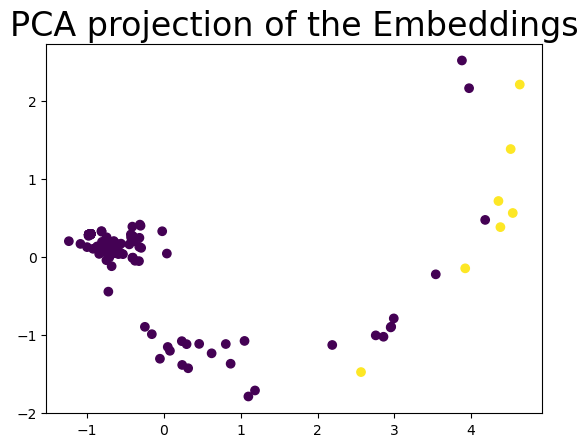

In [9]:
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

embeddings = [emb.detach().cpu().numpy() for emb in df['embeddings']] # convert it to numpy

embeddings = np.array(embeddings)

pca = PCA(n_components=2)
embedding_pca = pca.fit_transform(embeddings)

plt.scatter(embedding_pca[:, 0], embedding_pca[:, 1], c=df['numt'])
plt.title('PCA projection of the Embeddings', fontsize=24)
plt.show()


In [38]:
# PCA doesnt work with high dimention
# use t-sne or u-map (prefferebly this) for  vizualization 

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

matrix = torch.stack(list(sequenceEmbedings.values()))
pca = PCA(n_components=2)
pca_result = pca.fit_transform(matrix)


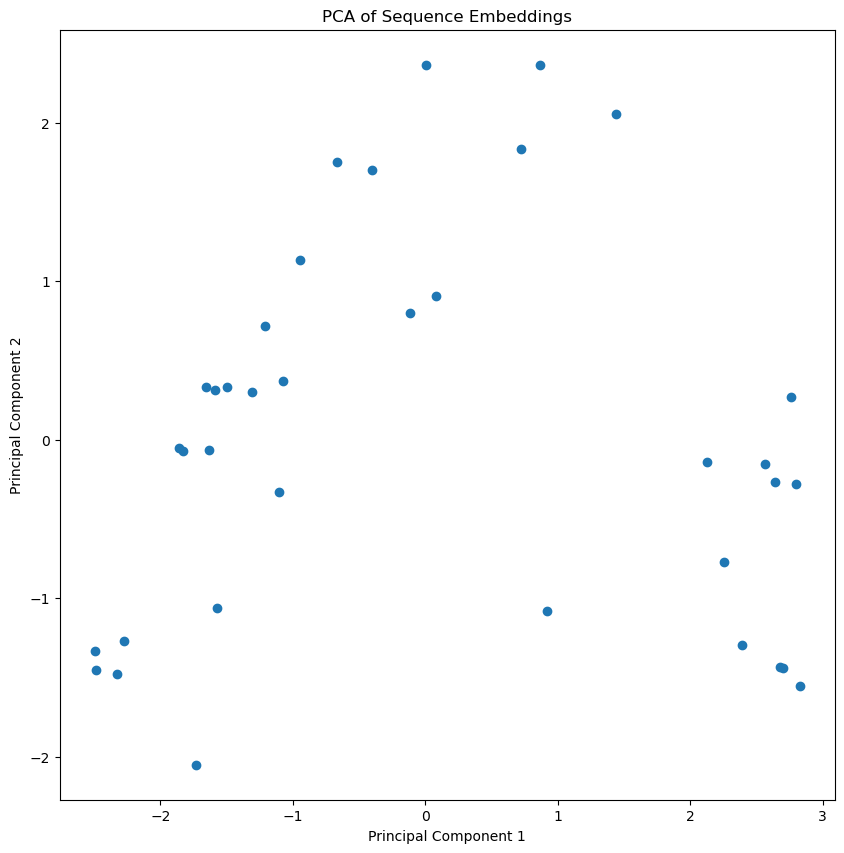

In [39]:

plt.figure(figsize=(10, 10))
plt.scatter(pca_result[:, 0], pca_result[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Sequence Embeddings')
plt.show()

In [42]:
df.columns

Index(['Species', 'Order', 'Family', 'Genus', 'NUMT.ID', 'Sequence',
       'Temp.BOLD.ID', 'Sequence.Length', 'Percent.ID', 'Indel', 'STOP',
       'IPSC', 'Size.Mb', 'N50', 'FCM', 'Coverage', 'Coverage.Category',
       'AminoAcidSeq'],
      dtype='object')

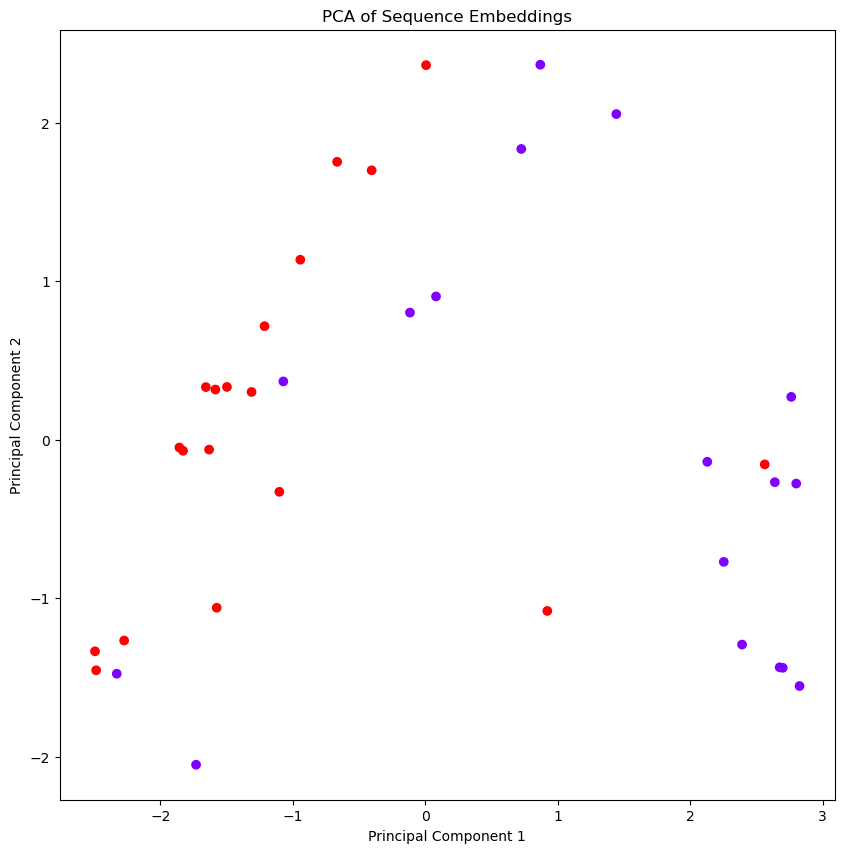

In [41]:
import numpy as np
import matplotlib.cm as cm

grouper = 'Family'
grouper = 'Genus'
grouper = 'STOP'
seq_to_family = df.set_index('AminoAcidSeq')[grouper].to_dict() # map sequence to family
families = list(df[grouper].unique())
colors = cm.rainbow(np.linspace(0, 1, len(families)))
family_to_color = dict(zip(families, colors))

colors = [family_to_color[seq_to_family[seq]] for seq in sequenceEmbedings.keys()]

plt.figure(figsize=(10, 10))
plt.scatter(pca_result[:, 0], pca_result[:, 1], color=colors)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Sequence Embeddings')
plt.show()
